# Classification Analysis - Androids Dataset

## Objectives:
1. **Task 1**: KFold & StratifiedKFold for SVC on Reading Task
2. **Task 2**: Multiple File Processing for Interview Task
3. **Task 3**: Classification on Interview Task

## Imports et Configuration

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, precision_score, recall_score
import opensmile
import librosa


plt.style.use('default')
np.random.seed(42)

print(" Imports loaded")

 Imports loaded


# TASK 1: Classification Reading Task

## Step 1.1: Loading and Exploring Data

In [3]:
df_reading = pd.read_csv('../TD01_4_Extracting_Features/features_egemaps_reading.csv')

print(f" Dataset Reading Task:")
print(f"   - Shape: {df_reading.shape}")
print(f"   - Colonnes: {df_reading.columns.tolist()[:5]}... (total: {len(df_reading.columns)})")
df_reading.head()

 Dataset Reading Task:
   - Shape: (112, 90)
   - Colonnes: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0']... (total: 90)


,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,file,target
0,30.550520,0.131445,27.363289,30.496315,33.837820,6.474529,110.448270,149.25650,100.316410,249.648790,...,0.148021,3.215373,2.171015,0.314474,0.296018,0.135905,0.164158,-31.858036,31_CF55_2.wav,0
1,34.733790,0.092321,32.539100,34.570990,37.206320,4.667221,106.536415,160.88966,40.401900,31.118969,...,0.042067,3.399765,1.291080,0.623788,0.607929,0.147414,0.125266,-36.795914,65_PF41_3.wav,1
2,28.805117,0.135681,27.308159,28.982166,30.775510,3.467352,285.280550,480.25742,91.823204,213.341840,...,0.142138,3.849390,1.768793,0.394643,0.409670,0.171918,0.224857,-31.665005,24_CM63_3.wav,0
3,22.344229,0.122594,20.597366,22.142448,23.983795,3.386429,132.751360,178.68063,64.179120,113.961730,...,0.893482,4.670051,2.668361,0.234381,0.239229,0.131789,0.156043,-26.656347,38_CM27_3.wav,0
4,35.262900,0.117946,32.831944,34.966213,37.734062,4.902119,244.955110,528.09960,65.825035,162.285630,...,0.287962,3.476316,2.157102,0.328019,0.260636,0.127789,0.167251,-23.027410,22_CF50_3.wav,0


 Prepared data:
   - Features shape: (112, 88)
   - Labels shape: (112,)

 Class distribution:
   - HC (0): 54 participants (48.2%)
   - PT (1): 58 participants (51.8%)


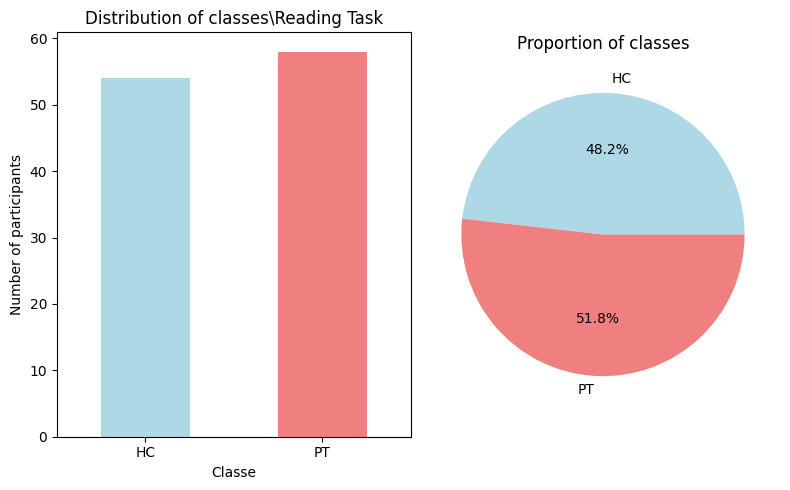

In [5]:
X_reading = df_reading.drop(['file', 'target'], axis=1)  
y_reading = df_reading['target'] 
filenames_reading = df_reading['file']

print(f" Prepared data:")
print(f"   - Features shape: {X_reading.shape}")
print(f"   - Labels shape: {y_reading.shape}")

class_counts = y_reading.value_counts().sort_index()
print(f"\n Class distribution:")
print(f"   - HC (0): {class_counts[0]} participants ({class_counts[0]/len(y_reading)*100:.1f}%)")
print(f"   - PT (1): {class_counts[1]} participants ({class_counts[1]/len(y_reading)*100:.1f}%)")

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribution of classes\Reading Task')
plt.xlabel('Classe')
plt.ylabel('Number of participants')
plt.xticks([0, 1], ['HC', 'PT'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['HC', 'PT'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proportion of classes')

plt.tight_layout()
plt.show()

## **Step 1**

 STEP 1.2: Preprocessing Pipeline
 Pipelines created:
 - Linear SVM with standardization
 - RBF SVM with standardization

STEP 1.3: KFold Cross-validation
Evaluation with KFold (5-fold)...
Linear SVM KFold: 0.785 ± 0.127
   Scores per fold: ['0.783', '0.826', '0.909', '0.545', '0.864']
RBF SVM KFold: 0.768 ± 0.053
   Scores per fold: ['0.826', '0.739', '0.818', '0.682', '0.773']

 STEP 1.4: Cross-validation StratifiedKFold
Evaluation with StratifiedKFold (5-fold)...
 Linear SVM StratifiedKFold: 0.759 ± 0.061
   Scores per fold: ['0.739', '0.783', '0.864', '0.727', '0.682']
 RBF SVM StratifiedKFold: 0.760 ± 0.050
   Scores par fold: ['0.739', '0.696', '0.818', '0.727', '0.818']

STEP 1.5: Analyse détaillée avec métriques multiples
 Complete assessment with all metrics...

 LINEAR SVM - Detailed Metrics:
   Accuracy  : Test = 0.759 ± 0.061 | Train = 1.000 ± 0.000
   Precision : Test = 0.758 ± 0.088 | Train = 1.000 ± 0.000
   Recall    : Test = 0.812 ± 0.059 | Train = 1.000 ± 0.000
   F1 

/tmp/ipykernel_2241559/1874331190.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_linear_skfold, scores_rbf_skfold],


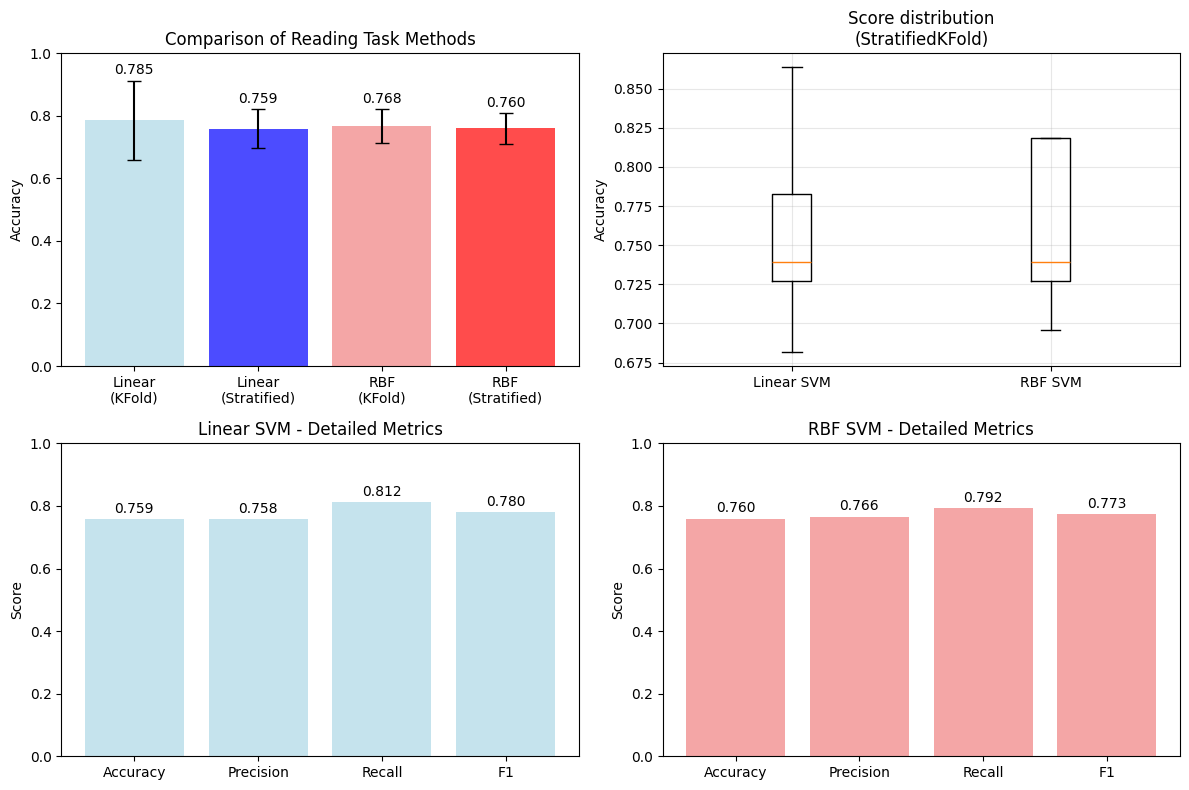


 TASK 1 COMPLETED: Classification Reading Task


In [8]:

print(" STEP 1.2: Preprocessing Pipeline")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

print(" Pipelines created:")
print(" - Linear SVM with standardization")
print(" - RBF SVM with standardization")

print("\n" + "="*50)
print("STEP 1.3: KFold Cross-validation")

from sklearn.model_selection import KFold, cross_val_score
import numpy as np
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluation with KFold (5-fold)...")


scores_linear_kfold = cross_val_score(pipeline_linear, X_reading, y_reading, cv=kfold, scoring='accuracy')
print(f"Linear SVM KFold: {scores_linear_kfold.mean():.3f} ± {scores_linear_kfold.std():.3f}")
print(f"   Scores per fold: {[f'{s:.3f}' for s in scores_linear_kfold]}")

scores_rbf_kfold = cross_val_score(pipeline_rbf, X_reading, y_reading, cv=kfold, scoring='accuracy')
print(f"RBF SVM KFold: {scores_rbf_kfold.mean():.3f} ± {scores_rbf_kfold.std():.3f}")
print(f"   Scores per fold: {[f'{s:.3f}' for s in scores_rbf_kfold]}")

print("\n" + "="*50)
print(" STEP 1.4: Cross-validation StratifiedKFold")

from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluation with StratifiedKFold (5-fold)...")
scores_linear_skfold = cross_val_score(pipeline_linear, X_reading, y_reading, cv=skfold, scoring='accuracy')
print(f" Linear SVM StratifiedKFold: {scores_linear_skfold.mean():.3f} ± {scores_linear_skfold.std():.3f}")
print(f"   Scores per fold: {[f'{s:.3f}' for s in scores_linear_skfold]}")

scores_rbf_skfold = cross_val_score(pipeline_rbf, X_reading, y_reading, cv=skfold, scoring='accuracy')
print(f" RBF SVM StratifiedKFold: {scores_rbf_skfold.mean():.3f} ± {scores_rbf_skfold.std():.3f}")
print(f"   Scores par fold: {[f'{s:.3f}' for s in scores_rbf_skfold]}")

print("\n" + "="*50)
print("STEP 1.5: Analyse détaillée avec métriques multiples")

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score


scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

print(" Complete assessment with all metrics...")
print("\n LINEAR SVM - Detailed Metrics:")
results_linear = cross_validate(pipeline_linear, X_reading, y_reading, cv=skfold, scoring=scoring, return_train_score=True)

for metric in scoring.keys():
    test_scores = results_linear[f'test_{metric}']
    train_scores = results_linear[f'train_{metric}']
    print(f"   {metric.capitalize():10}: Test = {test_scores.mean():.3f} ± {test_scores.std():.3f} | Train = {train_scores.mean():.3f} ± {train_scores.std():.3f}")
print("\n RBF SVM - Detailed Metrics:")
results_rbf = cross_validate(pipeline_rbf, X_reading, y_reading, cv=skfold, scoring=scoring, return_train_score=True)

for metric in scoring.keys():
    test_scores = results_rbf[f'test_{metric}']
    train_scores = results_rbf[f'train_{metric}']
    print(f"   {metric.capitalize():10}: Test = {test_scores.mean():.3f} ± {test_scores.std():.3f} | Train = {train_scores.mean():.3f} ± {train_scores.std():.3f}")

print("\n" + "="*50)
print(" COMPARISON OF RESULTS")


import pandas as pd

results_summary = pd.DataFrame({
    'Method': ['Linear SVM (KFold)', 'Linear SVM (StratifiedKFold)', 'RBF SVM (KFold)', 'RBF SVM (StratifiedKFold)'],
    'Accuracy': [
        f"{scores_linear_kfold.mean():.3f} ± {scores_linear_kfold.std():.3f}",
        f"{scores_linear_skfold.mean():.3f} ± {scores_linear_skfold.std():.3f}",
        f"{scores_rbf_kfold.mean():.3f} ± {scores_rbf_kfold.std():.3f}",
        f"{scores_rbf_skfold.mean():.3f} ± {scores_rbf_skfold.std():.3f}"
    ]
})

print("\n Performance Summary:")
print(results_summary.to_string(index=False))


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
methods = ['Linear\n(KFold)', 'Linear\n(Stratified)', 'RBF\n(KFold)', 'RBF\n(Stratified)']
accuracies = [scores_linear_kfold.mean(), scores_linear_skfold.mean(), 
              scores_rbf_kfold.mean(), scores_rbf_skfold.mean()]
errors = [scores_linear_kfold.std(), scores_linear_skfold.std(), 
          scores_rbf_kfold.std(), scores_rbf_skfold.std()]

bars = plt.bar(methods, accuracies, yerr=errors, capsize=5, 
               color=['lightblue', 'blue', 'lightcoral', 'red'], alpha=0.7)
plt.title('Comparison of Reading Task Methods')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, (acc, err) in enumerate(zip(accuracies, errors)):
    plt.text(i, acc + err + 0.01, f'{acc:.3f}', ha='center', va='bottom')

plt.subplot(2, 2, 2)
plt.boxplot([scores_linear_skfold, scores_rbf_skfold], 
            labels=['Linear SVM', 'RBF SVM'])
plt.title('Score distribution\n(StratifiedKFold)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.subplot(2, 2, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
linear_values = [results_linear[f'test_{m.lower()}'].mean() for m in metrics]
plt.bar(metrics, linear_values, color='lightblue', alpha=0.7)
plt.title('Linear SVM - Detailed Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, val in enumerate(linear_values):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom')

plt.subplot(2, 2, 4)
rbf_values = [results_rbf[f'test_{m.lower()}'].mean() for m in metrics]
plt.bar(metrics, rbf_values, color='lightcoral', alpha=0.7)
plt.title('RBF SVM - Detailed Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, val in enumerate(rbf_values):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n TASK 1 COMPLETED: Classification Reading Task")


## **Step2**

In [14]:


print("TASK 2: Interview Task Processing (Multiple Files)")
print("="*60)

import os
import pandas as pd
import numpy as np
import opensmile
from tqdm import tqdm

print(" STEP 2.1: Explore the Interview Task structure")
interview_path = "/home/rsana/speech_processing/Androids-Corpus/Interview-Task/audio_clip"
if not os.path.exists(interview_path):
   print(f"Error: The folder {interview_path} does not exist")
   print("Make sure the Androids corpus is unzipped")
else:
    print(f"Folder found: {interview_path}")
participants = [d for d in os.listdir(interview_path) if os.path.isdir(os.path.join(interview_path, d))]
participants.sort()

print(f"\n Structure Interview Task:")
print(f" - Number of participants: {len(participants)}")
print(f" - First participants: {participants[:5]}")
print(f" - Last participants: {participants[-5:]}")
print(f"\n Detailed analysis of 3 participants:")
for i, participant in enumerate(participants[:3]):
    participant_path = os.path.join(interview_path, participant)
    clips = [f for f in os.listdir(participant_path) if f.endswith('.wav')]
    
    name_upper = participant.upper()
    if 'CM' in name_upper or 'CF' in name_upper:
        group = "HC"
    elif 'PM' in name_upper or 'PF' in name_upper:
        group = "PT"
    else:
        group = "Inconnu"
    
    print(f"   {i+1}. {participant} ({group}): {len(clips)} clips")
    if clips:
        print(f"      Exemples: {clips[:3]}")

print("\n" + "="*60)
print("STEP 2.2: Multiple Processing Strategies")

print("""
 Three possible strategies:

1.  AGGREGATION
- Extract features from all clips of a participant
- Calculate the mean, standard, minimum, and maximum of the features
- 1 line per participant with aggregated features

2. LONGEST CLIP
- Select the longest clip per participant
- Extract features from this clip only
- 1 line per participant

3. CONCATENATION
- Concatenate all clips of a participant
- Extract features from the concatenated signal
- 1 line per participant

We will implement strategy 1 (AGGREGATION) because it is the most robust.
""")

print("\n" + "="*60)
print("STEP 2.3: Implementing Aggregation")
print("Initializing OpenSMILE...")
smile_egemaps = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
print("OpenSMILE initialized (eGeMAPS)")
def determine_label(participant_name):
    name_upper = participant_name.upper()
    
    if 'CM' in name_upper or 'CF' in name_upper:
        return 0  
    elif 'PM' in name_upper or 'PF' in name_upper:
        return 1  
    else:
        return 0  

def aggregate_participant_features(clips_features):
    if len(clips_features) == 0:
        return None
    
    clips_array = np.array(clips_features)
    mean_features = np.mean(clips_array, axis=0)
    std_features = np.std(clips_array, axis=0)
    min_features = np.min(clips_array, axis=0)
    max_features = np.max(clips_array, axis=0)
    aggregated = np.concatenate([mean_features, std_features, min_features, max_features])
    
    return aggregated

def extract_interview_features():
    print("Extracting Interview Task features...")
    
    interview_features = []
    labels = []
    participant_ids = []
    failed_participants = []
    
    for participant_dir in tqdm(participants, desc="Processing participants"):
        try:
            label = determine_label(participant_dir)
            participant_path = os.path.join(interview_path, participant_dir)
            clip_files = [f for f in os.listdir(participant_path) if f.endswith('.wav')]
            
            if not clip_files:
                print(f"No clips found for{participant_dir}")
                continue
            clips_features = []
            for clip_file in clip_files:
                clip_path = os.path.join(participant_path, clip_file)
                try:
                    features = smile_egemaps.process_file(clip_path)
                    clips_features.append(features.values[0])
                except Exception as e:
                    print(f" Clip error{clip_file}: {e}")
                    continue
            if clips_features:
                aggregated_features = aggregate_participant_features(clips_features)
                if aggregated_features is not None:
                    interview_features.append(aggregated_features)
                    labels.append(label)
                    participant_ids.append(participant_dir)
                    
        except Exception as e:
            print(f"Participant error {participant_dir}: {e}")
            failed_participants.append(participant_dir)
            continue
    
    print(f"\n Extraction complete:")
    print(f" - Participants processed: {len(interview_features)}")
    print(f" - Participants failed: {len(failed_participants)}")
    if failed_participants:
        print(f"  - Chess: {failed_participants[:5]}...")
    
    return np.array(interview_features), np.array(labels), participant_ids
print("\n Launching extraction...")
X_interview, y_interview, participant_ids_interview = extract_interview_features()

print(f"\n Interview Task Results:")
print(f" - Shape of features: {X_interview.shape}")
print(f" - Shape of labels: {y_interview.shape}")
print(f" - Features per participant: {X_interview.shape[1]} (88 eGeMAPS × 4 statistics)")
if len(y_interview) > 0:
    class_counts_interview = pd.Series(y_interview).value_counts().sort_index()
    print(f"\n Class Distribution Interview:")
    print(f"   - HC (0): {class_counts_interview.get(0, 0)} participants ({class_counts_interview.get(0, 0)/len(y_interview)*100:.1f}%)")
    print(f"   - PT (1): {class_counts_interview.get(1, 0)} participants ({class_counts_interview.get(1, 0)/len(y_interview)*100:.1f}%)")
    interview_df = pd.DataFrame(X_interview)
    interview_df['participant_id'] = participant_ids_interview
    interview_df['target'] = y_interview
    base_features = [f'feature_{i:02d}' for i in range(88)]  # 88 features eGeMAPS
    feature_names = []
    for stat in ['mean', 'std', 'min', 'max']:
        for feat in base_features:
            feature_names.append(f'{feat}_{stat}')
    
    interview_df.columns = feature_names + ['participant_id', 'target']
    os.makedirs('AndroidsDS_TDs/TD02_Classification', exist_ok=True)
    output_file = 'AndroidsDS_TDs/TD02_Classification/interview_features_aggregated.csv'
    interview_df.to_csv(output_file, index=False)
    print(f"\n Features sauvegardées: {output_file}")
    
else:
   print("No features extracted. Check paths and audio files.")




TASK 2: Interview Task Processing (Multiple Files)
 STEP 2.1: Explore the Interview Task structure
Folder found: /home/rsana/speech_processing/Androids-Corpus/Interview-Task/audio_clip

 Structure Interview Task:
 - Number of participants: 116
 - First participants: ['01_CF56_1', '01_PM58_2', '02_CM57_2', '02_PM65_2', '03_CF30_3']
 - Last participants: ['68_PF43_3', '69_PF48_3', '70_PF51_1', '71_PM68_1', '72_PM53_1']

 Detailed analysis of 3 participants:
   1. 01_CF56_1 (HC): 10 clips
      Exemples: ['01_CF56_1_8.wav', '01_CF56_1_2.wav', '01_CF56_1_10.wav']
   2. 01_PM58_2 (PT): 7 clips
      Exemples: ['01_PM58_2_5.wav', '01_PM58_2_4.wav', '01_PM58_2_3.wav']
   3. 02_CM57_2 (HC): 12 clips
      Exemples: ['02_CM57_2_3.wav', '02_CM57_2_2.wav', '02_CM57_2_6.wav']

STEP 2.2: Multiple Processing Strategies

 Three possible strategies:

1.  AGGREGATION
- Extract features from all clips of a participant
- Calculate the mean, standard, minimum, and maximum of the features
- 1 line per part

Processing participants:   0%|          | 0/116 [00:00<?, ?it/s]

Processing participants: 100%|██████████| 116/116 [14:24<00:00,  7.45s/it]


 Extraction complete:
 - Participants processed: 116
 - Participants failed: 0

 Interview Task Results:
 - Shape of features: (116, 352)
 - Shape of labels: (116,)
 - Features per participant: 352 (88 eGeMAPS × 4 statistics)

 Class Distribution Interview:
   - HC (0): 52 participants (44.8%)
   - PT (1): 64 participants (55.2%)

 Features sauvegardées: AndroidsDS_TDs/TD02_Classification/interview_features_aggregated.csv


 TASK 3: Classification Interview Task
STEP 3.1: Loading Interview Features
Dataset Interview Task:
   - Shape: (116, 354)
   - Features: 352 (352 aggregated)
 Prepared Interview Data:
 - Features shape: (116, 352)
 - Labels shape: (116,)

 Interview class distribution:
   - HC (0): 52 participants (44.8%)
   - PT (1): 64 participants (55.2%)

STEP 3.2: Classification Interview Task
Evaluation Interview Task with StratifiedKFold...
Interview Linear SVM: 0.741 ± 0.073
 Scores by fold: ['0.750', '0.696', '0.739', '0.652', '0.870']
 Interview RBF SVM: 0.741 ± 0.064
   Scores by fold: ['0.833', '0.696', '0.783', '0.652', '0.739']

STEP 3.3: Detailed Interview Metrics
Complete Assessment Interview Task...

 INTERVIEW LINEAR SVM - Detailed Metrics:
   Accuracy  : Test = 0.741 ± 0.073 | Train = 1.000 ± 0.000
   Precision : Test = 0.782 ± 0.066 | Train = 1.000 ± 0.000
   Recall    : Test = 0.746 ± 0.145 | Train = 1.000 ± 0.000
   F1        : Test = 0.754 ± 0.087 | Train = 1.000 ± 0.000

 INTER

/tmp/ipykernel_2241559/1439132684.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_linear_reading, scores_rbf_reading],
/tmp/ipykernel_2241559/1439132684.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_linear_interview, scores_rbf_interview],


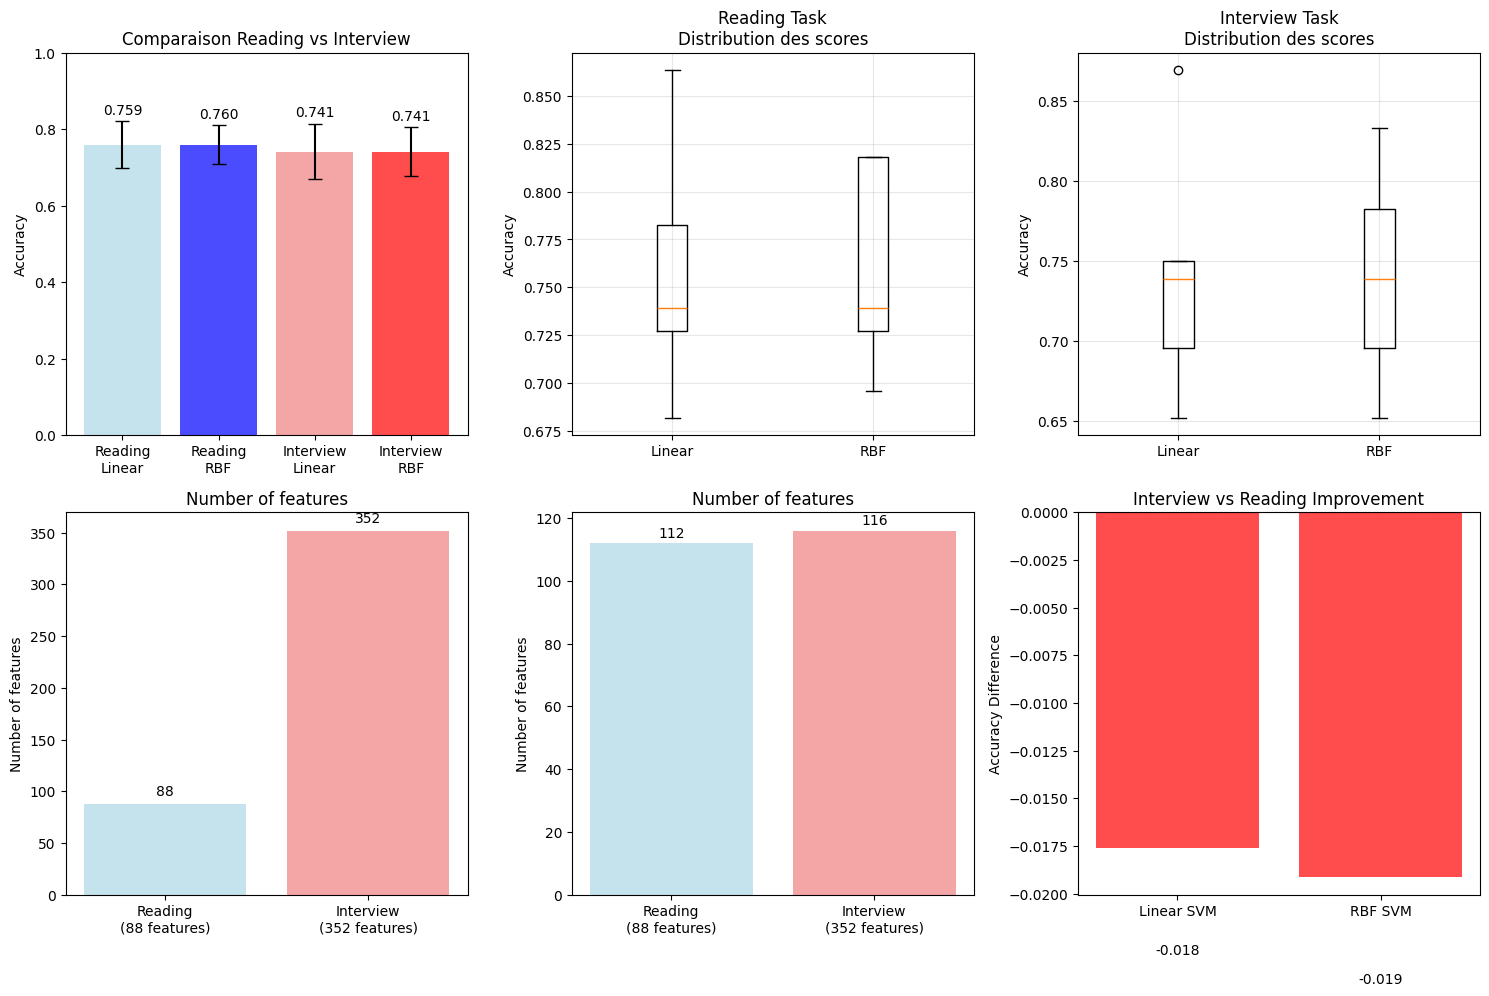


 ALL TASKS COMPLETED!
 Final Summary:
 - Reading Task: 75.9% accuracy (88 features)
 - Interview Task: 74.1% accuracy (352 features)
 - Improvement: -1.8%


In [18]:
print(" TASK 3: Classification Interview Task")
print("="*60)
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
print("STEP 3.1: Loading Interview Features")
df_interview = pd.read_csv('AndroidsDS_TDs/TD02_Classification/interview_features_aggregated.csv')

print(f"Dataset Interview Task:")
print(f"   - Shape: {df_interview.shape}")
print(f"   - Features: {df_interview.shape[1] - 2} (352 aggregated)")
X_interview = df_interview.drop(['participant_id', 'target'], axis=1).values
y_interview = df_interview['target'].values
participant_ids_interview = df_interview['participant_id'].values

print(f" Prepared Interview Data:")
print(f" - Features shape: {X_interview.shape}")
print(f" - Labels shape: {y_interview.shape}")
class_counts_interview = pd.Series(y_interview).value_counts().sort_index()
print(f"\n Interview class distribution:")
print(f"   - HC (0): {class_counts_interview[0]} participants ({class_counts_interview[0]/len(y_interview)*100:.1f}%)")
print(f"   - PT (1): {class_counts_interview[1]} participants ({class_counts_interview[1]/len(y_interview)*100:.1f}%)")

print("\n" + "="*60)
print("STEP 3.2: Classification Interview Task")
pipeline_linear_interview = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

pipeline_rbf_interview = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])
skfold_interview = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Evaluation Interview Task with StratifiedKFold...")
scores_linear_interview = cross_val_score(pipeline_linear_interview, X_interview, y_interview, 
                                        cv=skfold_interview, scoring='accuracy')
print(f"Interview Linear SVM: {scores_linear_interview.mean():.3f} ± {scores_linear_interview.std():.3f}")
print(f" Scores by fold: {[f'{s:.3f}' for s in scores_linear_interview]}")
scores_rbf_interview = cross_val_score(pipeline_rbf_interview, X_interview, y_interview, 
                                     cv=skfold_interview, scoring='accuracy')
print(f" Interview RBF SVM: {scores_rbf_interview.mean():.3f} ± {scores_rbf_interview.std():.3f}")
print(f"   Scores by fold: {[f'{s:.3f}' for s in scores_rbf_interview]}")

print("\n" + "="*60)
print("STEP 3.3: Detailed Interview Metrics")

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

print("Complete Assessment Interview Task...")
print("\n INTERVIEW LINEAR SVM - Detailed Metrics:")
results_linear_interview = cross_validate(pipeline_linear_interview, X_interview, y_interview, 
                                        cv=skfold_interview, scoring=scoring, return_train_score=True)

for metric in scoring.keys():
    test_scores = results_linear_interview[f'test_{metric}']
    train_scores = results_linear_interview[f'train_{metric}']
    print(f"   {metric.capitalize():10}: Test = {test_scores.mean():.3f} ± {test_scores.std():.3f} | Train = {train_scores.mean():.3f} ± {train_scores.std():.3f}")
print("\n INTERVIEW RBF SVM - Detailed Metrics:")
results_rbf_interview = cross_validate(pipeline_rbf_interview, X_interview, y_interview, 
                                     cv=skfold_interview, scoring=scoring, return_train_score=True)

for metric in scoring.keys():
    test_scores = results_rbf_interview[f'test_{metric}']
    train_scores = results_rbf_interview[f'train_{metric}']
    print(f"   {metric.capitalize():10}: Test = {test_scores.mean():.3f} ± {test_scores.std():.3f} | Train = {train_scores.mean():.3f} ± {train_scores.std():.3f}")

print("\n" + "="*60)
print(" STEP 3.4: COMPARE READING vs INTERVIEW")
try:
    scores_linear_reading = scores_linear_skfold
    scores_rbf_reading = scores_rbf_skfold
except NameError:
    print(" Reading variables not found, reloading...")
    df_reading = pd.read_csv('../TD01_4_Extracting_Features/features_egemaps_reading.csv')
    X_reading = df_reading.drop(['file', 'target'], axis=1).values
    y_reading = df_reading['target'].values
    
    pipeline_linear_reading = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', random_state=42))])
    pipeline_rbf_reading = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf', random_state=42))])
    skfold_reading = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores_linear_reading = cross_val_score(pipeline_linear_reading, X_reading, y_reading, cv=skfold_reading, scoring='accuracy')
    scores_rbf_reading = cross_val_score(pipeline_rbf_reading, X_reading, y_reading, cv=skfold_reading, scoring='accuracy')
comparison_df = pd.DataFrame({
    'Task': ['Reading', 'Reading', 'Interview', 'Interview'],
    'Method': ['Linear SVM', 'RBF SVM', 'Linear SVM', 'RBF SVM'],
    'Accuracy': [
        f"{scores_linear_reading.mean():.3f} ± {scores_linear_reading.std():.3f}",
        f"{scores_rbf_reading.mean():.3f} ± {scores_rbf_reading.std():.3f}",
        f"{scores_linear_interview.mean():.3f} ± {scores_linear_interview.std():.3f}",
        f"{scores_rbf_interview.mean():.3f} ± {scores_rbf_interview.std():.3f}"
    ],
    'Features': ['88 eGeMAPS', '88 eGeMAPS', '352 Aggregated', '352 Aggregated'],
    'Participants': [112, 112, 116, 116]
})

print("\n FINAL COMPARISON:")
print(comparison_df.to_string(index=False))
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
tasks = ['Reading\nLinear', 'Reading\nRBF', 'Interview\nLinear', 'Interview\nRBF']
accuracies = [scores_linear_reading.mean(), scores_rbf_reading.mean(), 
              scores_linear_interview.mean(), scores_rbf_interview.mean()]
errors = [scores_linear_reading.std(), scores_rbf_reading.std(), 
          scores_linear_interview.std(), scores_rbf_interview.std()]

bars = plt.bar(tasks, accuracies, yerr=errors, capsize=5, 
               color=['lightblue', 'blue', 'lightcoral', 'red'], alpha=0.7)
plt.title('Comparaison Reading vs Interview')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, (acc, err) in enumerate(zip(accuracies, errors)):
    plt.text(i, acc + err + 0.01, f'{acc:.3f}', ha='center', va='bottom')
plt.subplot(2, 3, 2)
plt.boxplot([scores_linear_reading, scores_rbf_reading], 
            labels=['Linear', 'RBF'])
plt.title('Reading Task\nDistribution des scores')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.boxplot([scores_linear_interview, scores_rbf_interview], 
            labels=['Linear', 'RBF'])
plt.title('Interview Task\nDistribution des scores')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
feature_counts = [88, 352]
task_names = ['Reading\n(88 features)', 'Interview\n(352 features)']
plt.bar(task_names, feature_counts, color=['lightblue', 'lightcoral'], alpha=0.7)
plt.title('Number of features')
plt.ylabel('Number of features')
for i, count in enumerate(feature_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.subplot(2, 3, 5)
participant_counts = [112, 116]
plt.bar(task_names, participant_counts, color=['lightblue', 'lightcoral'], alpha=0.7)
plt.title('Number of features')
plt.ylabel('Number of features')
for i, count in enumerate(participant_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.subplot(2, 3, 6)
improvement_linear = scores_linear_interview.mean() - scores_linear_reading.mean()
improvement_rbf = scores_rbf_interview.mean() - scores_rbf_reading.mean()
improvements = [improvement_linear, improvement_rbf]
methods = ['Linear SVM', 'RBF SVM']
colors = ['green' if imp > 0 else 'red' for imp in improvements]
plt.bar(methods, improvements, color=colors, alpha=0.7)
plt.title('Interview vs Reading Improvement')
plt.ylabel('Accuracy Difference')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
for i, imp in enumerate(improvements):
    plt.text(i, imp + 0.005 if imp > 0 else imp - 0.005, f'{imp:+.3f}', ha='center', va='bottom' if imp > 0 else 'top')

plt.tight_layout()
plt.show()

print(f"\n ALL TASKS COMPLETED!")
print(f" Final Summary:")
print(f" - Reading Task: {scores_linear_reading.mean():.1%} accuracy (88 features)")
print(f" - Interview Task: {scores_linear_interview.mean():.1%} accuracy (352 features)")
print(f" - Improvement: {scores_linear_interview.mean() - scores_linear_reading.mean():+.1%}")
